### Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm
tqdm.pandas()



/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
#!pip install sentence-transformers

In [2]:
df = pd.read_csv('../input/beer-project/BeerDataScienceProject.csv', encoding='latin-1')

In [3]:
df.shape

(528870, 13)

### Sneak-peek at data

In [4]:
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [5]:
df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

### Column Understanding 
- 'beer_abv' - alcohol by volumne (expressed as a volume percent) 5 indicates 5% of alcohol is present
- 'beer_beerId' - Beer id
- 'beer_brewerId' - Beer brewer id, breweries who produces beer
- 'beer_name' - name of beer
- 'beer_style' - beer style
- 'review_appearance' - rating based on appearance of beer
- 'review_palette' -  rating based on mouthfeel(most probably) of beer
- 'review_overall' - overall rating
- 'review_taste' - rating based on taste of beer
- 'review_profileName' - reviewer's name
- 'review_aroma' - rating based on aroma of beer
- 'review_text' - review given by beer taster
- 'review_time' - time at which review was written probably in seconds

Questions: 

1.	Rank top 3 Breweries which produce the strongest beers?
2.	Which year did beers enjoy the highest ratings? 
3.	 Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?
4.	If you were to recommend 3 beers to your friends based on this data which ones will you recommend?
5.	Which Beer style seems to be the favorite based on reviews written by users? 
6.	How does written review compare to overall review score for the beer styles?
7.	How do find similar beer drinkers by using written reviews only?   


### Null Value Check

In [6]:
df.isnull().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [7]:
# Null value check in percentage
df.isnull().sum()/ len(df) * 100 

beer_ABV              3.834591
beer_beerId           0.000000
beer_brewerId         0.000000
beer_name             0.000000
beer_style            0.000000
review_appearance     0.000000
review_palette        0.000000
review_overall        0.000000
review_taste          0.000000
review_profileName    0.021744
review_aroma          0.000000
review_text           0.022501
review_time           0.000000
dtype: float64

### Observations:-
- beer_Abv column contains ~4% of missing values.
- review_profileName contains 0.02% of missing values.
- review_text columns contains 0.02% of missing values


### High level statistics

In [8]:
df.describe()

,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time
count,508590.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,5.288700e+05
mean,7.017442,22098.466016,2598.423429,3.864522,3.758926,3.833197,3.765993,3.817350,1.224885e+09
std,2.204460,22158.284352,5281.805350,0.604010,0.685335,0.709962,0.669018,0.718903,7.605600e+07
min,0.010000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08
25%,5.300000,1745.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.174613e+09
50%,6.500000,14368.000000,394.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.240366e+09
75%,8.500000,40528.000000,1475.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.288560e+09
max,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09


## Question 1.	Rank top 3 Breweries which produce the strongest beers?

In [9]:
df['beer_brewerId'].nunique()

1803

### Let's check distribution of overall rating based on which strongest beers producing breweries will be found

<AxesSubplot:>

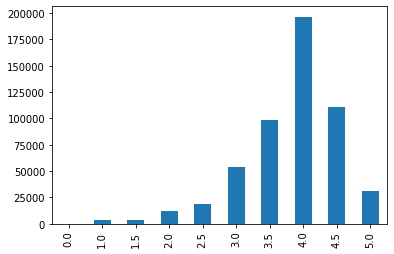

In [10]:
#sns.barplot(x=df['review_overall'].index, y=df['review_overall'].values)
df['review_overall'].value_counts().sort_index().plot(kind='bar')

In [11]:

print(np.mean(df['review_overall']), np.median(df['review_overall']))

3.8331971940174334 4.0


### Observations:-

- left skewed distribution
- Mode is 4,Median is 4,Mean is 3.83
- When distribution is skewed, median is better measure of central tendency because it isnt influenced by extremely large values while mean could.

In [12]:
top3_brewerid = df.groupby('beer_brewerId')['beer_ABV'].median().sort_values(ascending=False).head(3) # gives series
top3_brewerid 

beer_brewerId
736     14.0
5562    13.2
6513    13.0
Name: beer_ABV, dtype: float64

Text(0.5, 1.0, ' Top 3 Breweries producing strongest Beers')

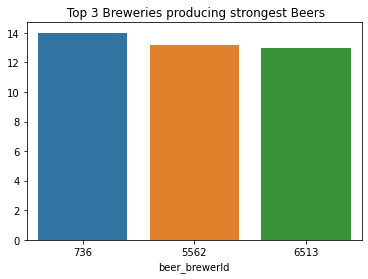

In [13]:
sns.barplot(x=top3_brewerid.index, y=top3_brewerid.values).set_title(" Top 3 Breweries producing strongest Beers")

## 2.	Which year did beers enjoy the highest ratings? 

In [14]:
# Converting review time to datetime format to extract year from it
pd.to_datetime(df['review_time'], unit='s')

0        2009-02-16 20:57:03
1        2009-03-01 13:44:57
2        2009-03-01 14:10:04
3        2009-02-15 19:12:25
4        2010-12-30 18:53:26
                 ...        
528865   2008-03-11 05:18:41
528866   2008-02-20 06:59:43
528867   2008-01-26 04:14:57
528868   2008-01-24 22:54:50
528869   2008-01-14 18:46:07
Name: review_time, Length: 528870, dtype: datetime64[ns]

In [15]:
df['review_year'] = pd.to_datetime(df['review_time'], unit='s').dt.year

In [16]:
df.groupby('review_year')['review_overall'].median().sort_values(ascending=False).head(1)

review_year
1998    4.0
Name: review_overall, dtype: float64

### Conclusion
- 1998 is the year in which beers enjoy maximum rating.

## 3.	 Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

In [ ]:
# https://quiktap.com/2017/10/30/art-beer-tasting-develop-palate/
# palette is mouthfeel of beer

In [ ]:
# Just to check whether review overall is the average rating of all 4 factors
# import math
# ((df['review_appearance']+df['review_palette']+df[ 'review_aroma'] + df['review_taste'] )/4)
# But that was not the case

### Approach: 

- Lets see what is correlation between these features
- Out of 4 some play important role in overall rting so this can be considered as weighted average of overall rating. Linear regression can help here.

<AxesSubplot:>

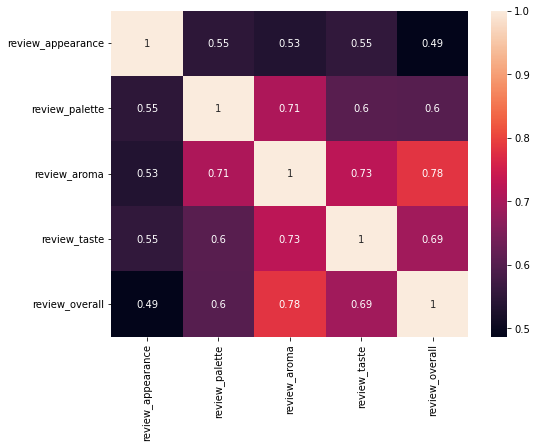

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['review_appearance', 'review_palette', 'review_aroma', 'review_taste','review_overall']].corr(), annot=True)

In [18]:
reg = LinearRegression().fit(df[['review_appearance', 'review_palette', 'review_aroma', 'review_taste']], df['review_overall'])
reg.coef_

array([0.0330351 , 0.04492507, 0.5531015 , 0.25941546])

## Observations:-
- From both correlation heat map and linear regression suggests aroma is the most important factor followed by taste.
- Oh but wait linear regression suffers from multicollinearity, can we consider this weights as final one? I don't think so.
- We should remove it and then train the model. But if we remove highcorrelated features how we will check which one of them is important
- If we apply PCA then also we will loose interpretation of original features.
- Lets try a model which is immune to multicollinearity. Reference link: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4 <br>Tree Based Models :) Lets apply random forest and get feature importance.


In [19]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameter_grid = {
               'min_samples_leaf': [3,5,7],
               'min_samples_split': [5,7, 10],
               'n_estimators': [100, 300, 500]}

model2 = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=33, min_samples_leaf=10)
rf_grid = GridSearchCV(model2, param_grid=parameter_grid,n_jobs=-1,cv=3)
rf_grid.fit(df[['review_appearance', 'review_palette', 'review_aroma', 'review_taste']], df["review_overall"])

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 2min 49s, sys: 565 ms, total: 2min 50s
Wall time: 58min 49s


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(min_samples_leaf=10, n_jobs=-1,
                                             random_state=33),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [5, 7, 10],
                         'n_estimators': [100, 300, 500]})

In [20]:
best_model = rf_grid.best_estimator_
best_model.feature_importances_

array([0.00701176, 0.00594047, 0.93214315, 0.05490462])

### Conclusion:-
- Feature Aroma is the most important factor in deciding overall rating followed by feature taste.

## 4) If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

Approach: 
- To 3 Beers which will have highest overall rating 


In [21]:
df['beer_beerId'].nunique(), df.shape

# Number of unique beers are around 20K, Total number of rows wr have around 5lakh so 1 beer is having more then 1 review 

(20200, (528870, 14))

In [22]:
top_rated_beers = df.groupby('beer_beerId')['review_overall'].median().sort_values(ascending=False)

In [23]:
print(top_rated_beers[top_rated_beers == 5].shape)
top_rated_beers[top_rated_beers == 5]

(296,)


beer_beerId
74712    5.0
61988    5.0
63673    5.0
41973    5.0
75076    5.0
        ... 
12413    5.0
53233    5.0
55434    5.0
51535    5.0
16043    5.0
Name: review_overall, Length: 296, dtype: float64

### There are 296 total beers which is having overall review rating 5. How to extract top5 from it? 
Approach: We can extract top 3 breweries. Coz brand always plays an important role for any customer while buying beers.

In [24]:
top_breweries = df.groupby('beer_brewerId')['review_overall'].median().sort_values(ascending=False)
top_breweries[top_breweries==5]

beer_brewerId
24056    5.0
3625     5.0
6225     5.0
21109    5.0
13866    5.0
3700     5.0
387      5.0
5961     5.0
Name: review_overall, dtype: float64

In [25]:
top_beers_index = top_rated_beers[top_rated_beers == 5].index.tolist()
top_brew_index = top_breweries[top_breweries==5].index.tolist()

In [27]:
df.loc[(df['beer_brewerId'].isin(top_brew_index))&(df['beer_beerId'].isin(top_beers_index))].shape

(10, 14)

### Conclusion
We get 10 beers using the above logic which can be further filtered based on person's preferences like some people prefer to have good aroma while others have the criteria of anything would be fine except having bitter taste.

### 5) Which Beer style seems to be the favorite based on reviews written by users?

In [28]:
df['beer_style'].nunique()

104

In [29]:
# Reviews with overall rating greater than 4 has been selected as positive review else negative review.
# Priorly review threshold of 3.5 was considered but that lead to very imbalanced distribution and 
# to select favorite or top beer styles my subspace should be smaller
df['review_sentiment'] = df['review_overall'].apply(lambda x: 1 if x>4 else 0)

In [30]:
df[df['review_overall']==4]['review_text'].iloc[0]

"According to the website, the style for the Caldera Cauldron changes every year. The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back). In any event... at the Horse Brass yesterday. The beer pours an orange copper color with good head retention and lacing. The nose is all hoppy IPA goodness, showcasing a huge aroma of dry citrus, pine and sandlewood. The flavor profile replicates the nose pretty closely in this West Coast all the way DIPA. This DIPA is not for the faint of heart and is a bit much even for a hophead like myslf. The finish is quite dry and hoppy, and there's barely enough sweet malt to balance and hold up the avalanche of hoppy bitterness in this beer. Mouthfeel is actually fairly light, with a long, persistentely bitter finish. Drinkability is good, with the alcohol barely noticeable in this well crafted beer. Still, this beer is so hugely hoppy/bi

<AxesSubplot:>

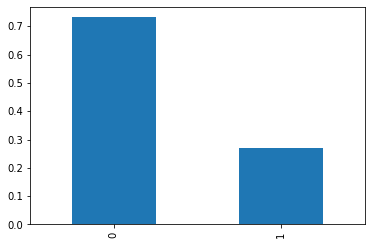

In [31]:
df['review_sentiment'].value_counts(normalize=True).plot(kind='bar')

In [32]:
top3_beerids = df.groupby('beer_beerId')['review_sentiment'].sum().sort_values(ascending=False).head(3).index
top3_beerids.tolist()

[11757, 34, 1904]

In [33]:
df.groupby('beer_style')['review_sentiment'].sum().sort_values(ascending=False).head(3).index

Index(['American IPA', 'American Double / Imperial Stout',
       'American Double / Imperial IPA'],
      dtype='object', name='beer_style')

### 6) How does written review compare to overall review score for the beer styles?

### Text Preprocessing
- Convert to lowercase.
- Performed word decontractions eg: won't is converted into will not.
- Any non-alphanumeric letters if present is removed as it does not add any valuable information.
- Stop words removal but 'not' and 'very' are very important stopwords which could play vital role in negative and positive review sentiment so we will exclude it from the list of stopwords.
- Word lemmatization - convert words to its stem word which does make sense.

In [34]:
# # https://stackoverflow.com/a/47091490/4084039
from nltk.corpus import stopwords
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def text_preprocessing(text):
    '''This function does text preprocessing 
       It includes removal of html tags,
       converting to lowercase, 
       decontraction and 
       removal of any non alphanumeric characters.
       
       Function takes one parameter - text
       returns - preprocessed text
    '''
    
    # Convert each word to lowercase
    text = text.lower()
    # text decontraction. eg: won't to will not. Can't to cannot
    text = decontracted(text)
    # Remove any non-alphanumeric characters if present
    text = re.sub('\W', ' ',text).strip()
    # lemmatization with stop words removal
    lemmatizer = WordNetLemmatizer()
    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    text = text.strip()
    return text

In [35]:
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.remove('very')
len(stop_words)

177

In [36]:
#print(df['review_text'].isnull().sum()
df.shape[0]-df['review_text'].isnull().sum()
df.dropna(subset=['review_text'], inplace=True)
df.shape

(528751, 15)

In [37]:
df['Cleaned_review_text'] = df['review_text'].progress_apply(lambda x: text_preprocessing(x))

100%|██████████| 528751/528751 [05:34<00:00, 1582.95it/s]


In [38]:
df['Cleaned_review_text'].head()

0    lot foam lot smell banana lactic tart not good...
1    dark red color light beige foam average smell ...
2    almost totally black beige foam quite compact ...
3    golden yellow color white compact foam quite c...
4    according website style caldera cauldron chang...
Name: Cleaned_review_text, dtype: object

### Approach 1: Lets analyze word frequency- Wordcloud based on different levels of overall ratings

<AxesSubplot:>

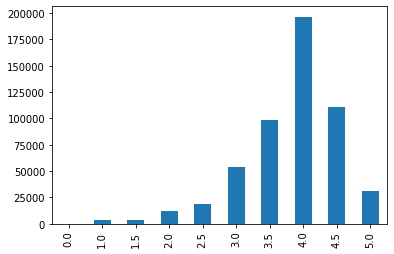

In [39]:
df['review_overall'].value_counts().sort_index().plot(kind='bar')

- Manual cluster1 - rating 0 to 2.5
- Manual cluster2 - raitng 3 to 3.5
- Manual cluster3 - rating 4
- Manual cluster4 - rating 4.5 to 5

In [40]:
from wordcloud import WordCloud
from datetime import datetime



def plot_word_clouds(df, n_gram_tuple):
    vectorizer = CountVectorizer(tokenizer = lambda x: x.split(),ngram_range=n_gram_tuple)
    # fit function learns the vocabulary; 
    vectorizer.fit(df['Cleaned_review_text'])
    vocab = vectorizer.get_feature_names()
    print("Unique number of words: ", len(vocab))
    # Create bow matrix - each of unique word will be columns and each row will have 1 corresponding to that word
    # present in that review
    bow_matrix = vectorizer.fit_transform(df['Cleaned_review_text'])
    # If we sum over each word column we will have word frequency
    word_freq = bow_matrix.sum(axis=0).A1 # .A1 returns flattened array of matrix
    result = dict(zip(vocab,word_freq))
  

    # Lets first convert the 'result' dictionary to 'list of tuples'
    tup = dict(result.items())
    #Initializing WordCloud using frequencies of words.
    
    wordcloud = WordCloud(background_color='black'
                        ).generate_from_frequencies(tup)

    fig = plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

(190338, 16)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Unique number of words:  84583


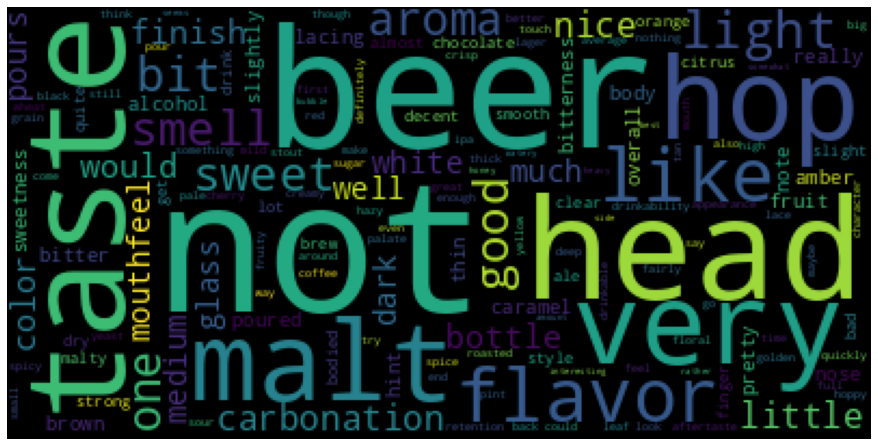

Unique number of words:  2412880


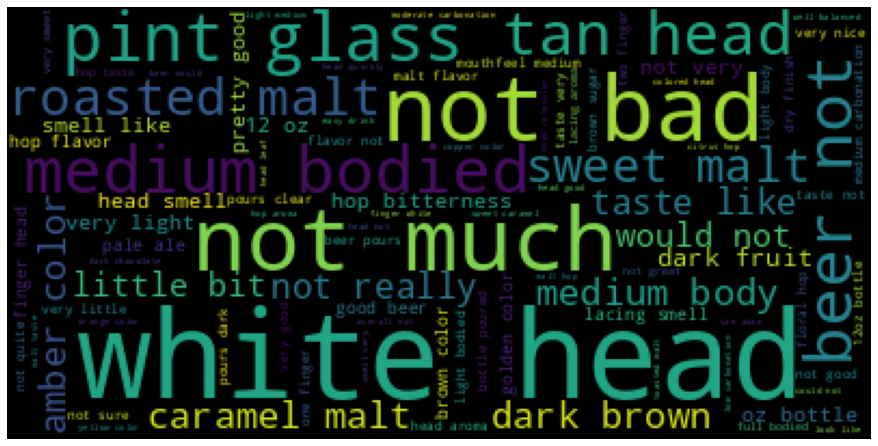

CPU times: user 1min 22s, sys: 2.22 s, total: 1min 24s
Wall time: 1min 24s


In [41]:
%%time
poor_df = df[(df['review_overall']>0) & (df['review_overall']<=3.5)]
print(poor_df.shape)
plot_word_clouds(poor_df,(1,1))
plot_word_clouds(poor_df,(2,2))

## Observations:-
Reviews with overall rating from 0 to 3.5 has been considered. Assuming its a poor to average reviews category.
- Word 'not' seems to be the most frequent word in lower rating reviews which makes sense as user did not like the beer, did not like the taste or aroma etc.
- Other words such as 'beer', 'taste', 'flavor', 'smell','like','very' are in high frequency which suggests it would have been used in negative sense such as user didn't like the flavor, or beer tastes bitter
- Bigram wordcloud says 'white head' is most frequent. But
    - it also includes bigram phrases such as 'not bad', 'not much' which falls into average category reviews.
    - Bigram phrases such as 'not really', 'would not', 'not very','not great' suggests user didnt liked the beer and these reviews probably fall into poor category.

(196501, 16)
Unique number of words:  82954


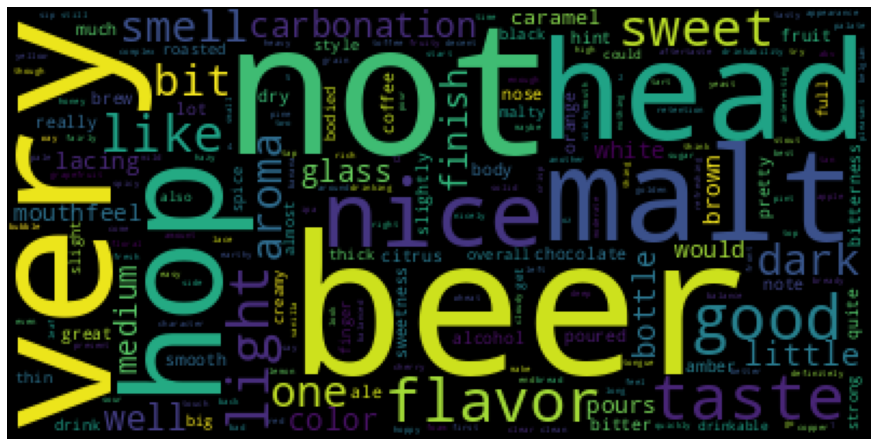

Unique number of words:  2366013


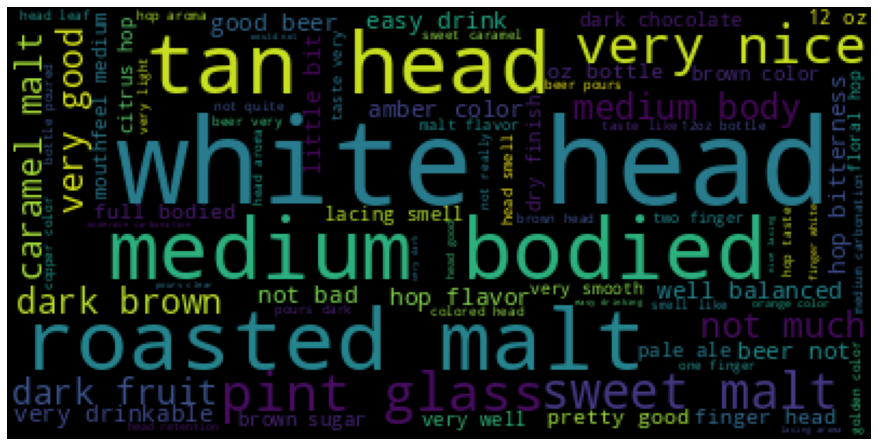

In [43]:
good_df = df[(df['review_overall']==4.0)]
print(good_df.shape)

plot_word_clouds(good_df, (1,1))
plot_word_clouds(good_df, (2,2))

### Observations:-
Reviews with rating 4 has been considered in this cluster. Ideally we could have merge reviews with rating 4,4.5 and 5 but ratings have skewed distribution and rating 4 is the most frequent rating found. So lets analyze it seperately.
- Unigram worcloud contains words like 'beer', 'very', 'not'.
- Bigram word cloud includes phrases like 'white head', 'medium bodied', tan head' not very useful for us. But it also includes phrases like 'good beer', 'sweet malt', 'very nice', 'preety good' which suggets its a good beer. 
- Notice how it doesnt contain any negative bigrams.

(141909, 16)
Unique number of words:  77780


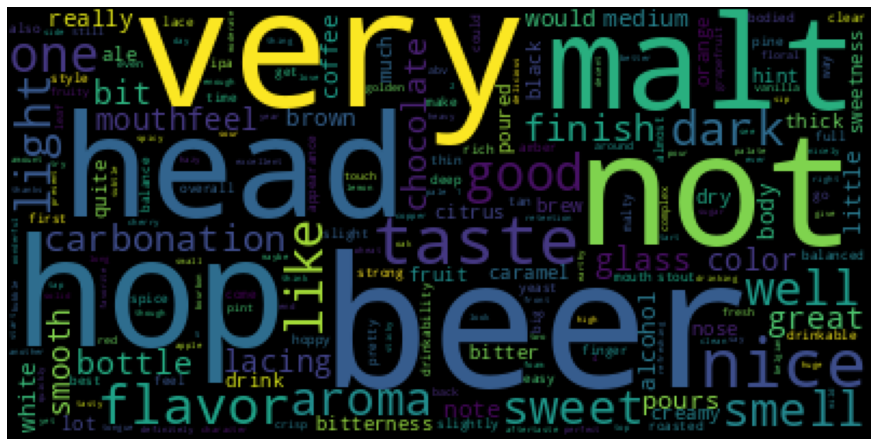

Unique number of words:  2187868


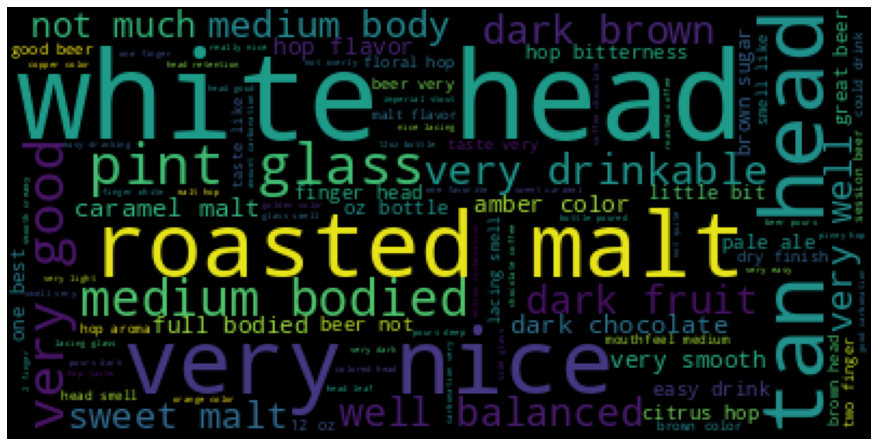

In [44]:
great_df = df[(df['review_overall']>=4.5)]
print(great_df.shape)

plot_word_clouds(great_df, (1,1))
plot_word_clouds(great_df, (2,2))

### Observations:-
- Unigram wordcloud shows 'very', 'beer', 'not','head','taste','nice' are some of the most frequent words.
- But unigram does include positive words like 'nice', 'good', 'great' which suggests its a positive review.
- More clarity can be obtained by studying bigram wordcloud which includes bigram phrases like 'very nice', 'very good', 'very drinkable'.

### Let's verify above conclusion through a different approach

### Approach 2: Based on Review Sentiment Score

- Nltk's sentiment intensity analyzer gives polarity scores which includes how much negative , positive, neutral and compound given sentence sounds.
- Compound score can be considered as one metric to cummulate the overall polarity of a sentence

- reference for compound explanation: https://github.com/cjhutto/vaderSentiment <br>
    - The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

    - It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

    - positive sentiment: compound score >= 0.05 <br>
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05) <br>
    - negative sentiment: compound score <= -0.05 <br>
    - NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.
#### Example:-

In [45]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

print(df['review_text'].iloc[8800])
ss = sid.polarity_scores(df['review_text'].iloc[8800])
print(ss)

# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
I go this in a trade, but for the life of me I can't figure out who sent it to me! So, apologies are due to the kind trader who included this brew. Pours black and slightly viscous with a decent head that fades to a ring. Nicely balanced bourbon, toasted grains, and sweet malt with a good deal of creaminess. The bourbon is on the mellow side, but nicely nuanced with caramel, oak, vanilla, and cream. Unfortunately the bourbon is a good deal too subtle for my taste in the flavor and the malt profile doesn't have enough oomph either. Still, its pleasant enough if kinda light. Smooth and somewhat creamy in the mouth, this is easy to drink- maybe a little too easy for the style.
{'neg': 0.021, 'neu': 0.736, 'pos': 0.244, 'compound': 0.9885}


### Computing review_polarity for all the reviews

In [46]:
sid = SentimentIntensityAnalyzer()
df['review_polarity'] = df['review_text'].progress_apply(lambda x:sid.polarity_scores(x)['compound'])


100%|██████████| 528751/528751 [13:15<00:00, 664.40it/s]


Text(0.5, 1.0, 'Review polarity distribution')

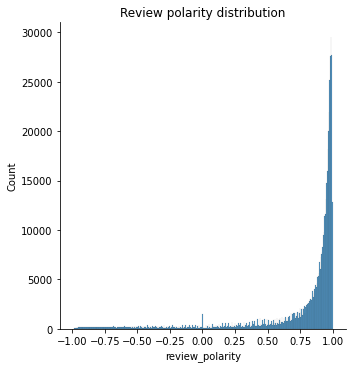

In [57]:
sns.displot(df['review_polarity'])
plt.title("Review polarity distribution")

- Left skewed distribution
- Taking median makes sense

In [58]:
df.groupby('beer_style').agg({'review_polarity': np.median,
                  'review_overall': np.median
                  }).sort_values(['review_polarity','review_overall'], ascending=[False,False]).reset_index()

,beer_style,review_polarity,review_overall
0,American Double / Imperial Stout,0.9593,4.0
1,Wheatwine,0.9591,4.0
2,Quadrupel (Quad),0.9554,4.0
3,American Wild Ale,0.9544,4.0
4,Lambic - Fruit,0.9524,4.0
...,...,...,...
99,American Adjunct Lager,0.8271,3.0
100,American Malt Liquor,0.8159,3.0
101,Japanese Rice Lager,0.7845,3.0
102,Low Alcohol Beer,0.7789,2.5


### Conclusion:-
- Review text does affect/contribute in overall rating of the reviews. 



### 7) How do find similar beer drinkers by using written reviews only?

### Approach 1: Using tfidf features + cosine similarity

In [ ]:
# %%time
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(stop_words='english') # originally 149965
# tfidf.fit(df['review_text'])
# print(len(tfidf.vocabulary_))
# text_features = tfidf.transform(df['review_text'])
# text_features.shape

# from sklearn.metrics.pairwise import cosine_similarity
# cos_sim = cosine_similarity(text_features)

### Observation:-
- Above technique was tried but couldn't work due to computational limitations.
- Requires lot of Ram

### Will Word2vec technique be suitable?


In [59]:
df['Review_length'] = df['Cleaned_review_text'].progress_apply(len)

100%|██████████| 528751/528751 [00:01<00:00, 440149.48it/s]


Text(0.5, 1.0, 'Review length Distribution')

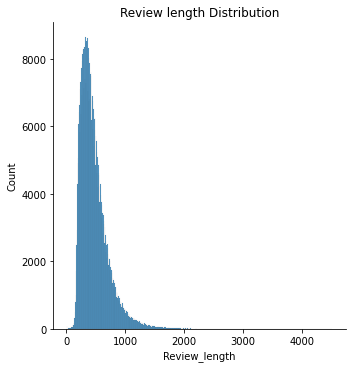

In [60]:
sns.displot(df['Review_length'])
plt.title("Review length Distribution")

In [61]:
df['Review_length'].describe()

count    528751.000000
mean        473.559161
std         247.259610
min           4.000000
25%         304.000000
50%         416.000000
75%         575.000000
max        4519.000000
Name: Review_length, dtype: float64

### Observations:-
- Length of revies have a bit skewed distribution.
- Length of reviews range from 4 to 4519 but 25% of reviews are greater than 304 which suggests reviews are very lengthy.
- Applying average w2v doesnt make sense since it will average all word embeddings.
- Concatenating all words embedding will increase number of dimensions for which enough computational power is not there.


## Sentence Bert 

SBERT Overview: <br>
 - Sentence-BERT(SBERT), a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity.
 
- Sbert derived sentence embeddings significantly outperform other state-of-the-art sentence embedding methods like InferSent (Conneau et al., 2017) and Universal Sentence Encoder (Cer et al., 2018).

- we use the pre-trained BERT and RoBERTa network and only fine-tune it to yield useful sentence embeddings. This reduces significantly the needed training time: SBERT can be tuned in less than 20 minutes, while yielding  better results than comparable sentence embedding methods.



https://www.sbert.net/examples/applications/semantic-search/README.html


Problem with BERT: <br>
 - A common method to address semantic search problems is to map each sentence to a vector space such that semantically similar sentences are close. 
 - Researchers have experimented with inputting individual sentences into BERT and to derive fixedsize sentence embeddings. The most commonly used approach is to average the BERT output layer(known as BERT embeddings) or by using the output of the first token (the [CLS] token). 
 
 - Paper shows experimentation of using input of individual sentences into BERT, deriving fixed size sentence embeddings(most popular approach is to average the BERT output layer or by using the output of the first token (the [CLS] token)) is ofthen worse than using average Glove embeddings.

In [62]:
%%time
corpus = df['Cleaned_review_text'].values.tolist()
len(corpus)

CPU times: user 24.2 ms, sys: 992 µs, total: 25.2 ms
Wall time: 24.8 ms


528751

In [63]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embedder = embedder.to('cuda') # To use gpu

In [64]:
%%time
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

Batches:   0%|          | 0/16524 [00:00<?, ?it/s]

CPU times: user 7min 27s, sys: 4.26 s, total: 7min 31s
Wall time: 5min 42s


In [65]:
import pickle
with open("sentence-embeddings.pkl", "wb") as fOut:
    pickle.dump(corpus_embeddings,fOut)

In [66]:
import pickle
with open('./sentence-embeddings.pkl', 'rb') as obj:
    embeddings = pickle.load(obj)

### Approach 1: To find similar beer drinkers
Calculate cosine similarity of each user with evey other user(considering all rows)

In [ ]:
# %%time 
# from sklearn.metrics.pairwise import cosine_similarity
# #cos_sim = cosine_similarity(embeddings.iloc[0].values.reshape(1, -1), embeddings.values)
# cos_sim = cosine_similarity(embeddings.values)

### Drawback
- Shape of df is 528751 rows and 100 dimensional sentence embeedings (using any technique).
- In total 52875100 values of type float 16.
- 1 float16 value takes 2 bytes i.i 16 bits of memory.
- 105750200 bytes ~ 103271.68 kb ~ 100GB
- 100GB of Ram is required to get whole cosine similarity matrix of shape 528751*528751 which is not feasible on this machine with 16gb of ram

### Approach 2: Embedding Clustering
- Using embedding of review text, perform clustering, so that similar reviews will be clustered together.
- Study the clusters obtained and draw similar beer drinkers from that.
- This approach will also require all the embeddings to be in memory, thus not feasible.

### Approach 3: Given a beer drinker find similar beer drinker

In [67]:
def get_similar_beerdrinker(review_text_of_beer_drinker):
    user_review_embedding = review_text_of_beer_drinker
    # Compute cosine similarity between user review embedding and whole corpus embedding
    cos_scores = util.pytorch_cos_sim(user_review_embedding, embeddings)[0]
    # get top3 similar users
    top_results = torch.topk(cos_scores, k=3) 
    top_results[1].cpu() # require to get in cpu memory
    similar_drinkers_with_index = np.unique(df['review_profileName'].iloc[top_results[1].cpu()].values, return_index=True)
    return similar_drinkers_with_index
    

In [68]:
similar_drinker = get_similar_beerdrinker(embeddings[0][0:]) # passing first users review text embedding
print("Similar drinkers: ",similar_drinker[0])
print("Index: ",similar_drinker[1] )

Similar drinkers:  ['froghop' 'stcules']
Index:  [2 0]


In [ ]:
########################################## THE END ###################################################################